In [1]:
import numpy as np
from numba import njit, prange
from timeit import default_timer as timer
import matplotlib
from matplotlib import pylab
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 10
sgm = 10
threshold = 70
S = 576
R_initial = 32
eta = S*.1

In [3]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b):

    alpha = a
    beta = b

    #S = (w11+w12-beta) * R_initial**2 + (1-alpha) * R_initial
    V1 = S*(1+coh)
    V2 = S*(1-coh)

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    R1_arr[0], R2_arr[0] = R_initial, R_initial
    # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
    # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        for ti in range(1, int(dur/dt)):

            if ti % 5 == 0:
                V1 = S*(1+coh) + np.random.randn() * eta
                V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold:
                choice[i] = 1
                reaction_time[i] = ti
                break
            elif R2_arr[ti] > threshold:
                reaction_time[i] = ti
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice


In [5]:
alpha = 30
beta1, beta2, beta3, beta4, beta5, beta6 = .9, 1.1, 1.3, 1.5, 1.6, 1.7
b1_reaction_time, b1_choice = np.zeros(1000), np.zeros(1000)
b2_reaction_time, b2_choice = np.zeros(1000), np.zeros(1000)
b3_reaction_time, b3_choice = np.zeros(1000), np.zeros(1000)
b4_reaction_time, b4_choice = np.zeros(1000), np.zeros(1000)
b5_reaction_time, b5_choice = np.zeros(1000), np.zeros(1000)
b6_reaction_time, b6_choice = np.zeros(1000), np.zeros(1000)

In [6]:
start = timer()
for coh in range(-500, 500):
    a1_b1_RT, a1_b1_c = ave_choice(coh / 1000, alpha, beta1)
    b1_reaction_time[coh+500], b1_choice[coh+500] = np.nanmean(a1_b1_RT)*dt, np.nanmean(a1_b1_c)

    a1_b2_RT, a1_b2_c = ave_choice(coh / 1000, alpha, beta2)
    b2_reaction_time[coh+500], b2_choice[coh+500] = np.nanmean(a1_b2_RT)*dt, np.nanmean(a1_b2_c)

    a1_b3_RT, a1_b3_c = ave_choice(coh / 1000, alpha, beta3)
    b3_reaction_time[coh+500], b3_choice[coh+500] = np.nanmean(a1_b3_RT)*dt, np.nanmean(a1_b3_c)

    a1_b4_RT, a1_b4_c = ave_choice(coh / 1000, alpha, beta4)
    b4_reaction_time[coh+500], b4_choice[coh+500] = np.nanmean(a1_b4_RT)*dt, np.nanmean(a1_b4_c)

    a1_b5_RT, a1_b5_c = ave_choice(coh / 1000, alpha, beta5)
    b5_reaction_time[coh+500], b5_choice[coh+500] = np.nanmean(a1_b5_RT) * dt, np.nanmean(a1_b5_c)

    a1_b6_RT, a1_b6_c = ave_choice(coh / 1000, alpha, beta6)
    b6_reaction_time[coh+500], b6_choice[coh+500] = np.nanmean(a1_b6_RT) * dt, np.nanmean(a1_b6_c)

    print("\r[EPOCH]: %d" % (coh+500), end='')
end = timer()-start

[EPOCH]: 999

In [7]:
x_axis = np.zeros(1000)
for ind, coh in enumerate(range(-500, 500)):
    x_axis[ind] = 2*S*coh/1000

parameters = [.6, beta1, beta2, beta3, beta4, beta5, beta6]
norm = matplotlib.colors.Normalize(vmin=np.min(parameters), vmax=np.max(parameters))

c_m = plt.cm.get_cmap('BuPu')
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)

In [8]:
def draw_RT():
    plt.plot(x_axis, b1_reaction_time, color=s_m.to_rgba(parameters[1]))
    plt.plot(x_axis, b2_reaction_time, color=s_m.to_rgba(parameters[2]))
    plt.plot(x_axis, b3_reaction_time, color=s_m.to_rgba(parameters[3]))
    plt.plot(x_axis, b4_reaction_time, color=s_m.to_rgba(parameters[4]))
    plt.plot(x_axis, b5_reaction_time, color=s_m.to_rgba(parameters[5]))
    plt.plot(x_axis, b6_reaction_time, color=s_m.to_rgba(parameters[6]))

    plt.title("Speed")
    plt.xlabel("Input difference")
    plt.ylabel("Reaction Time (s)")

    ax = plt.gca()
    ax.xaxis.set_ticks(np.arange(-500, 501, 250))

    ax.tick_params(axis='x', direction="in")
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(bottom=True, left=True)
    ax.spines['bottom'].set_color('0')
    ax.spines['left'].set_color('0')
    ax.patch.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    font_size = 20
    params = {'figure.figsize': (7, 6),
             'legend.fontsize': font_size,
             'axes.labelsize': font_size,
             'axes.titlesize': font_size,
             'xtick.labelsize': font_size,
             'ytick.labelsize': font_size}
    pylab.rcParams.update(params)

    fig = ax.figure
    cbar_ax = fig.add_axes([1, 0.25, 0.05, 0.5])
    plt.grid(False)
    bar = fig.colorbar(s_m, cax=cbar_ax)
    #cbar_ax.set_label("Disinhibition Stronger")

    #plt.savefig("beta_RT.tiff", format="tiff", bbox_inches='tight')
    plt.savefig("graphs/changing_beta_RT.eps", format="eps", bbox_inches='tight')

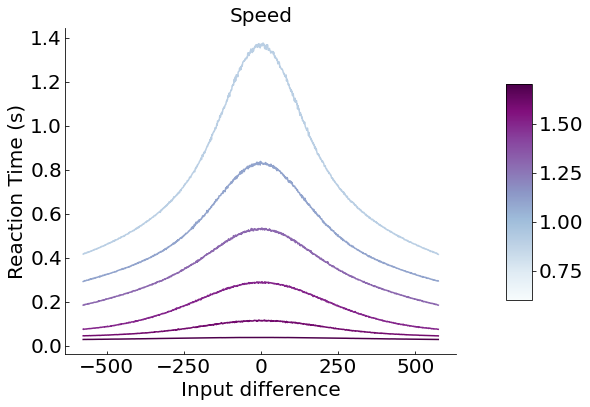

In [10]:
draw_RT()

In [11]:
def draw_choice():
    plt.plot(x_axis, b1_choice, color=s_m.to_rgba(parameters[0]))
    plt.plot(x_axis, b2_choice, color=s_m.to_rgba(parameters[1]))
    plt.plot(x_axis, b3_choice, color=s_m.to_rgba(parameters[2]))
    plt.plot(x_axis, b4_choice, color=s_m.to_rgba(parameters[3]))
    plt.plot(x_axis, b5_choice, color=s_m.to_rgba(parameters[4]))
    plt.plot(x_axis, b6_choice, color=s_m.to_rgba(parameters[5]))

    plt.title("Accuracy")
    plt.xlabel("Input difference")
    plt.ylabel("p(chosen option 1)")
    ax = plt.gca()
    ax.xaxis.set_ticks(np.arange(-500, 501, 250))
    ax.yaxis.set_ticks(np.arange(0, 1.25, .25))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax.tick_params(axis='x', direction="in")
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(bottom=True, left=True)
    ax.spines['bottom'].set_color('0')
    ax.spines['left'].set_color('0')
    ax.patch.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    font_size = 20
    params = {'figure.figsize': (7, 6),
             'legend.fontsize': font_size,
             'axes.labelsize': font_size,
             'axes.titlesize': font_size,
             'xtick.labelsize': font_size,
             'ytick.labelsize': font_size}
    pylab.rcParams.update(params)

    fig = ax.figure
    cbar_ax = fig.add_axes([1, 0.25, 0.05, 0.5])
    plt.grid(False)
    fig.colorbar(s_m, cax=cbar_ax)

    #plt.savefig("beta_choice.tiff", format="tiff", bbox_inches='tight')
    plt.savefig("graphs/changing_beta_AC.eps", format="eps", bbox_inches='tight')

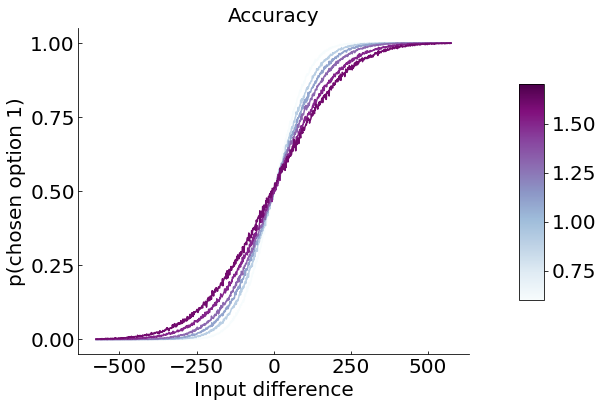

In [12]:
draw_choice()